In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50 # Modelo ya preentrenado
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from sklearn.model_selection import train_test_split

In [ ]:
os.listdir()

In [2]:
df = pd.read_csv('defect_and_no_defect.csv')
df_defect = pd.read_csv('train.csv')

In [ ]:
''' Aquí tenemos el dataset con el nombre de la imagen (vemos que es un archivo jpg), la clase de fallo que tiene
 en ClassId y el encodedPixels que es la imagen codificada.'''


df_defect.head()

In [ ]:
# Queremos ver si una imagen tiene mas de 2 fallos, algo que es posible
# Cuando sumemos la columna nueva 'mask' y nos da más del largo del dataset veremos que hay imagenes repetidas

df_defect['mask'] = df_defect.loc[:,'ClassId'].map(lambda x:1)

In [ ]:
# Vamos a ver cuantas imagenes hay con cada defecto
# Tenemos un data set desbalanceado. Veremos a ver si usamos smote

sns.countplot(data = df_defect,
             x = 'ClassId')
plt.title('Número de imágenes por tipo de error')
plt.show()

In [ ]:
# Gracias a la columna de 1 que hemos creado vemos que hay 272 imágenes que tienen 2 fallos y 1 con 3

sns.barplot(x = df_defect.groupby(['ImageId'])['mask'].sum().value_counts().index,
           y = df_defect.groupby(['ImageId'])['mask'].sum().value_counts())
plt.title('Número de defectos en imágenes')
plt.show()

print(df_defect.groupby(['ImageId'])['mask'].sum().value_counts())

In [ ]:
df.columns

In [ ]:
# Vemos si el data set con todas las imágenes está desbalanceada

sns.countplot(data = df,
             x = 'label')
plt.title('Núemero de imágenes con y sin defecto')
plt.show()

In [ ]:
print(os.getcwdb())
print(os.listdir())

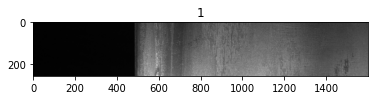

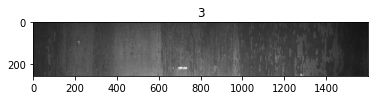

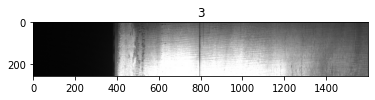

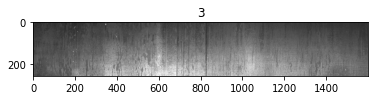

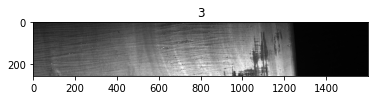

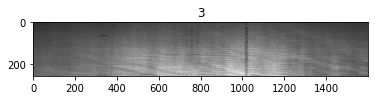

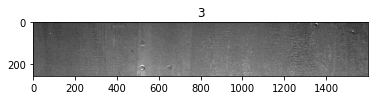

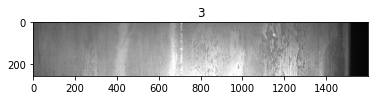

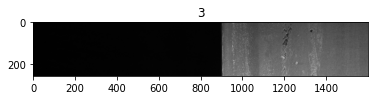

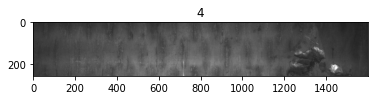

In [8]:
train_dir = '/home/nestor/Proyectos/Udemy Data Science/Tarea 7/train_images/'

for i in range(10):
    img = io.imread(os.path.join(train_dir, df_defect.ImageId[i]))
    plt.figure()
    plt.title(df_defect.ClassId[i])
    plt.imshow(img)


In [ ]:
# Esto me traduce de la RLE pasa a mascara y luego de mascara a RLE

from utilities import rle2mask , mask2rle

In [ ]:
df_defect.columns

In [ ]:
mask = rle2mask(df_defect.loc[21, 'EncodedPixels'], img.shape[0], img.shape[1]) #img shape lo indica las medidas de la imagen

mask.shape

In [ ]:
# Ejemplo de lo que hace este paquete de 'rle2mask'
plt.imshow(mask)

In [ ]:
# Aquí vemos que en el shape se nos ha añadido un 3. Estos son los 3 colores rojo, azul y verde.

img = io.imread(os.path.join(train_dir, df_defect.ImageId[21]))
plt.imshow(img)
img.shape

In [ ]:
# Pintamos las imágenes con la máscara encima

for i in range(10):
    
    #cargamos imagen y la paso a color
    img = io.imread(os.path.join(train_dir, df_defect.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #creo la máscar
    mask = rle2mask(df_defect.loc[i,'EncodedPixels'], img.shape[0], img.shape[1])
    
    #pintamos las fotos
    img[mask == 1,1] = 255 # donde la máscara sea 1(fallo) lo pinto en verde para verlo
    plt.figure()
    plt.imshow(img)
    plt.title(df_defect.loc[i, 'ClassId'])

# Red neuronal; primer paso --> decir si tiene o no fallo

En este problema las imágenes las tengo en el mismo directorio que se llama 'train'. A veces, los datos ya vienen divididos por directorios de test, train y validation.

In [ ]:
df

In [ ]:
train, test = train_test_split(df, test_size = 0.15)

In [ ]:
# Cargar las imágenes puede ser tedioso para la máquina, usaremos image generator
# También haremos una validación cruzada

from keras_preprocessing.image import ImageDataGenerator

In [ ]:
gen = ImageDataGenerator(rescale=1./255., validation_split=0.15) # Me quedo con el 15 por ciento de train y escalo(0,1)

train_gen = gen.flow_from_dataframe(dataframe = train,
                                   directory = train_dir,
                                   x_col = 'ImageID', # El nombre de la imagen guardado en la carpeta
                                   y_col = 'label', # Para saber si tiene o no defecto
                                   subset = 'training',
                                   batch_size = 16,
                                   shuffle = True,
                                   class_mode = 'other',
                                   target_size = (256,256) # Aquí reducimos(lote)
                                   )

valid_gen = gen.flow_from_dataframe(dataframe = train,
                                   directory = train_dir,
                                   x_col = 'ImageID',
                                   y_col = 'label',
                                   subset = 'validation',
                                   batch_size = 16,
                                   shuffle = True,
                                   class_mode = 'other',
                                   target_size = (256,256)
                                   )

# Aquí ya hemos creado dos flujos de imágenes, las de entrenar y para validar

In [ ]:
# Ahora preparo las imágenes para test

test_datagen = ImageDataGenerator(rescale=1./255.) #Aquí llamo al objeto con el reescalado. La imagen que le meta me la 'genera'

test_gen = test_datagen.flow_from_dataframe(dataframe = test,
                                           directory = train_dir,
                                           x_col = 'ImageID',
                                           y_col = None,
                                           batch_size = 16,
                                           shuffle = False,
                                           class_mode = None,
                                           target_size = (256,256))


In [ ]:
# Red base. Nos descargamos el modelo preentrenado de google

base = ResNet50(weights='imagenet',
               include_top = False, #El input lo voy a elegir yo
               input_tensor = Input(shape = (256,256,3)))# 256 son los lotes de imágenes y el 3 los colores rojo, azul, verde.

In [ ]:
# Vamos a congelar las capas de la red

for capa in base.layers:
    layers.trainable = False

In [ ]:
headmodel = base.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel) #resumimos
headmodel = Flatten(name = 'flatten')(headmodel) #aplanamos
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel) #Drop out para evitar overfiting
headmodel = Dense(1, activation = 'sigmoid')(headmodel) #La sigmoide es porque vamos a tener un res binario

modelo = Model(inputs = base.input, outputs = headmodel)

In [ ]:
# Compilamos el modelo con 'binary crossentropy' ya que nuestro problema es binario

modelo.compile(loss = 'binary_crossentropy', 
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [ ]:
#Para evitar overfiting vamos a usar el early stoping. Esto tiene sentido sobre todo cuando tiene muchas capas, como este algortimo

earlystop = EarlyStopping(monitor='val_loss',
                         mode = 'min',
                         verbose = 1,
                         patience = 20)

#Este codigo es para guardar el mejor modelo

checkpoint = ModelCheckpoint(filepath = 'resnet-pesos.hdf5',
                            verbose = 1,
                            save_best_only=True)

In [ ]:
red_res = modelo.fit(train_gen,
                    steps_per_epoch=train_gen.n//64,
                    epochs = 2,
                    validation_data=valid_gen,
                    validation_steps= valid_gen.n//64,
                    callbacks = [checkpoint, earlystop],
                    verbose = 1)

In [ ]:
train_gen.n

In [ ]:
# Hacre predicciones con 2 epochs. Este resultado no va a ser tan completo, pero nos sirve para practicar

test_predict = modelo.predict(test_gen, steps = test_gen.n//16, verbose = 1)

In [ ]:
# 0 = no defecto
# 1 = defecto

predict = list()

for i in test_predict:
    if i < 0.1:
        predict.append(0)
    else:
        predict.append(1)
        
predict = np.array(predict)

In [ ]:
len(predict)

In [ ]:
''' Las label o clasificación de error no error de mis datos de test los convierto a array y cojo 480 como mi 
prediccion para poder hacer el accuracy y la matriz de confusión'''

origin = np.array(test.label)[:1936]

In [ ]:
# Aunque el acuracy indica que el modelo acierta más del 50 por ciento, es un resultado bastante malo

from sklearn.metrics import accuracy_score

print(accuracy_score(origin, predict))

In [ ]:
# Aquí está la clave, nuestro modelo clasifica todas las imagenes como que no tiene error, un indicador muy malo
''' La red, con 2 épocas y tantas capas, no le da tiempo a entrenarse bien. Por ello, tenemos un modelo guardado
con mas epochs y con resultados más prometedores.'''

from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(origin, predict), annot = True)

# Evaluar el modelo guardado con 40 epochs

In [ ]:
'''Esta evaluaciń no va a ser con el modelo con una iteración. Ya tengo guardado el modelo con más epochs que,
por falta de recursos de mi pc, no he entrenado en local'''

# Abrimos el json

with open('resnet-classifier-model.json', 'r') as json_file:
    json_model = json_file.read()

# Cargamos la arquitectura del modelo
model = tf.keras.models.model_from_json(json_model)

# Cargamos los pesos del modelo
model.load_weights('resnet-weights.hdf5')

#compilamos
model.compile(loss = 'binary_crossnetropy',
             optimizer = 'Nadam',
             metrics = ['acuracy'])

In [ ]:
# Hacemos una predicción del modelo con las 40 iteraciones. En teoría, debería ser un mejor modelo

test_predict = model.predict(test_gen,
                            steps = test_gen.n//16,
                            verbose = 1)

In [ ]:
predict = list()

for i in test_predict:
    if i < 0.1:
        predict.append(0)
    else:
        predict.append(1)
        
predict = np.array(predict)
len(predict)

In [ ]:
#Aquí ya vemos una notable mejora en el accuracy del modelo
from sklearn.metrics import accuracy_score

print(accuracy_score(origin, predict))

In [ ]:
# Matriz de confusión. Aún así, sige fallando bastante
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(origin, predict), annot = True)

In [ ]:
'''Vemos que, aunque no sea un modelo demasiado bueno, ya que el recall de las imágenes sin defecto es algo vago,
es un comienzo para tener resultados aceptables y del cual se puede partir para ir mejorando. Esto también se 
puede deber a que no se hayan realizado las suficientes epochs para dar lugar a que el modelo aprenda.'''

from sklearn.metrics import classification_report

print(classification_report(origin, predict, labels = [0,1]))